<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>


# Testing of web services deployed on ACI and AKS

## Table of content
1. [Introduction](#intro)
1. [Pre-requisites](#pre-reqs)
  1. [Tools](#tools)
  1. [Existing objects](#exist-obj)
1. [Library import](#imports)
1. [Workspace retrieval](#workspace)
1. [Service retrieval](#service)
1. [Testing of the web services](#testing)
  1. [Using the *run* API](#run)
  1. [Via a raw HTTP request](#request)
  1. [Using a user interface - Locally](#local)
    1. [From the terminal](#terminal)
	1. [From this notebook](#ntbk)
  1. [Using a user interface - Online](#online)
    1. [Dockerization of our application](#docker)
	1. [Registration of the Docker image into the Azure Container Registry](#register)
	1. [Installation and configuration of kubectl](#kube)
	1. [Creation of a static IP address](#static)
	1. [Deployment of our registered Docker container on AKS](#deploy)
	1. [Website testing](#web_test)
1. [Service telemetry in Application Insights](#insights)
1. [Clean up](#clean)
  1. [Static IP address detachment/deletion](#del_ip)
  1. [Flask app service and deployment deletion](#del_svc)
  1. [Application Insights deactivation and web service termination](#del_app_insights)
  1. [Docker image deletion](#del_image)
1. [Resources](#resources)

## 1. Introduction <a id="intro"/>
In the 2 prior notebooks, we deployed our machine learning model as a web service on [Azure Container Instances](https://github.com/Microsoft/ComputerVisionBestPractices/blob/staging/image_classification/notebooks/21_deployment_on_azure_container_instances.ipynb) (ACI) and on [Azure Kubernetes Service](https://github.com/Microsoft/ComputerVision/blob/staging/image_classification/notebooks/22_deployment_on_azure_kubernetes_service.ipynb) (AKS). In this notebook, we will learn how to test our service:
- Using the `run` API
- Via a raw HTTP request
- Through a locally run Flask app
- Through the same Flask app, deployed on the same AKS cluster, as a separate web service.

## 2. Pre-requisites <a id="pre-reqs"/>

### 2.A Tools <a id="tools"/>
    
In addition to the "cvbp" conda environment, and account on the Azure platform, we will need three other tools:
- The Azure CLI, which installation instructions are provided [here](https://docs.microsoft.com/en-us/cli/azure/install-azure-cli?view=azure-cli-latest)
- The Kubernestes CLI, which we will install together in this notebook
- Docker, which we will use to containerize our application. If we don't have it installed on our machine, we can follow the instructions below to do so:
  - [Linux](https://docs.docker.com/install/linux/docker-ce/ubuntu/)
  - [MacOS](https://docs.docker.com/docker-for-mac/install/)
  - [Windows](https://docs.docker.com/docker-for-windows/install/)
  
      In case of issues, troubleshooting documentation can be found [here](https://docs.docker.com/docker-for-windows/troubleshoot/#running-docker-for-windows-in-nested-virtualization-scenarios). Additionally, we can follow the steps below, if we have a Windows machine:
    - Go to `Task Manager > Performance`
    - Check that `Virtualization` is enabled
    - If it is not, go to `Start > Settings > Update and security > Recovery > Advanced Startup - Restart now > Troubleshoot > Advanced options > UEFI firmware settings - restart`
    - In the BIOS, go to `Advanced > System options > Click on "Virtualization Technology (VTx) only" > Save > Exit > Save all changes` -- This will restart the machine


### 2.B Existing objects <a id="exist-obj"/>
As the work we will do here is based on what we did in prior tutorials, we are assuming that we already have:
- A workspace
- An web service that serves our machine learning model on ACI and/or AKS.
    
If that is not the case, we can refer to the two notebooks linked in the "1. Introduction" section.

## 3. Library import <a id="imports"/>
    
Let's start by importing the libraries we will need to access our Azure workspace and the test data.

In [1]:
# For automatic reloading of modified libraries
%reload_ext autoreload
%autoreload 2

# Regular python libraries
import inspect
import os
import requests
import sys

# fast.ai
from fastai.vision import *

# Azure
import azureml.core
from azureml.core import Workspace

# Computer Vision repository
sys.path.extend([".", "../.."])
from utils_cv.common.data import data_path
from utils_cv.common.image import im2base64, ims2strlist

In [2]:
# Check core SDK version number
print(f"Azure ML SDK Version: {azureml.core.VERSION}")

## 4. Workspace retrieval <a id="workspace">

Let's now retrieve our workspace from the configuration file we already created and that was saved in the `aml_config/` folder.

In [3]:
ws = Workspace.from_config()

Let's make sure that it was loaded properly

In [4]:
# Print the workspace attributes
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

## 5. Service retrieval <a id="service">

If we have not deleted them in the 2 prior deployment notebooks, the web services we deployed on ACI and AKS should still be up and running. Let's check if that is indeed the case.

In [5]:
ws.webservices

{'aks-cpu-image-classif-web-svc': <azureml.core.webservice.aks.AksWebservice at 0x1cb3bf716d8>,
 'im-classif-websvc': <azureml.core.webservice.aci.AciWebservice at 0x1cb3bf719b0>}

This command should return a dictionary, which keys are the names we gave to our web services.

Let's now retrieve the web services of interest.

In [6]:
# Retrieve the web services
aci_service = ws.webservices['im-classif-websvc']
aks_service = ws.webservices['aks-cpu-image-classif-web-svc']

## 6. Testing of the web services <a id="testing">

In a real case scenario, we would only have one of these 2 services running. In this section, we show how to test that the web service running on ACI is working as expected. The commands we will use here are exactly the same as those we would use for our service running on AKS. We would just need to replace the `aci_service` object by the `aks_service` one.

Let's now test our web service. For this, we first need to retrieve test images and to pre-process them into the format expected by our service. A service typically expects input data to be in a JSON serializable format. Here, we use our own `ims2strlist()` function to transform our .jpg images into strings of bytes.

In [7]:
# Check the source code of the conversion functions
im2base64_source = inspect.getsource(im2base64)
im2strlist_source = inspect.getsource(ims2strlist)
print(im2base64_source)
print(im2strlist_source)

In [8]:
# Extract test images paths
im_url_root = "https://cvbp.blob.core.windows.net/public/images/"
im_filenames = ["cvbp_milk_bottle.jpg", "cvbp_water_bottle.jpg"]

local_im_paths = []
for im_filename in im_filenames:
    # Retrieve test images from our storage blob
    r = requests.get(os.path.join(im_url_root, im_filename))

    # Copy test images to local data/ folder
    with open(os.path.join(data_path(), im_filename), 'wb') as f:
        f.write(r.content)

    # Extract local path to test images
    local_im_paths.append(os.path.join(data_path(), im_filename))

# Convert images to json object
im_string_list = ims2strlist(local_im_paths)
test_samples = json.dumps({"data": im_string_list})

### 6.A Using the *run* API <a id="run">
To facilitate the testing of both services, we create here an extra object `service`, which can take either the ACI or the AKS web service object. This would not be needed in a real case scenario, as we would have either the ACI- or the AKS-hosted service only.

In [9]:
service = aci_service
# service = aks_service

In [10]:
# Predict using the deployed model
result = service.run(test_samples)

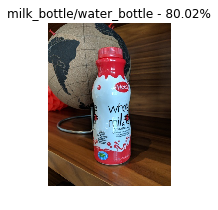

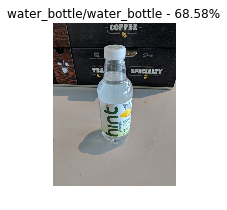

In [11]:
# Plot the results
actual_labels = ['milk_bottle', 'water_bottle']
for k in range(len(result)):
    title = f"{actual_labels[k]}/{result[k]['label']} - {round(100.*float(result[k]['probability']), 2)}%"
    open_image(local_im_paths[k]).show(title=title)

### 6.B Via a raw HTTP request <a id="request">

In the case of AKS, we need to provide an authentication key. So let's look at the 2 examples separately, with the same testing data as before.

In [12]:
# On ACI

# Extract service URL
service_uri = aci_service.scoring_uri
print(f"POST requests to url: {service_uri}")

# Prepare the data
payload = {"data": im_string_list}

# Send the service request
resp = requests.post(service_uri, json=payload)

# Alternative way of sending the test data
# headers = {'Content-Type':'application/json'}
# resp = requests.post(service_uri, test_samples, headers=headers)

print(f"Prediction: {resp.text}")

Prediction: [{"label": "water_bottle", "probability": "0.8001841306686401"}, {"label": "water_bottle", "probability": "0.68577641248703"}]


In [13]:
# On AKS

# Service URL
service_uri = aks_service.scoring_uri
print(f"POST requests to url: {service_uri}")

# Prepare the data
payload = {"data": im_string_list}

# - - - - Specific to AKS - - - -
# Authentication keys
primary, secondary = aks_service.get_keys()
print(f"Keys to use when calling the service from an external app: {[primary, secondary]}")

# Build the request's parameters
key = primary
# Set the content type
headers = { 'Content-Type':'application/json' }
# Set the authorization header
headers['Authorization']=f'Bearer {key}'
# - - - - - - - - - - - - - - - -

# Send the service request
resp = requests.post(service_uri, json=payload, headers=headers)
# Alternative way of sending the test data
# resp = requests.post(service_uri, test_samples, headers=headers)

print(f"Predictions: {resp.text}")

Predictions: [{"label": "water_bottle", "probability": "0.8001841306686401"}, {"label": "water_bottle", "probability": "0.68577641248703"}]


### 6.C Using a user interface - Locally <a id="local"/>

This notebook is accompanied by 3 files, stored in the `flask_app/` folder:
- application.py
- templates/index.html
- templates/template.html

They construct a Flask application that will allow us to interact with our web service.

We can run this application in 2 different ways:
1. From a terminal window, in our conda environment
2. From within this notebook

<i><b>Note:</b> In this section, we will use the web service hosted on AKS. This will be helpful when we deploy our Flask application on the same AKS cluster.</i>

#### 6.C.a From the terminal <a id="terminal"/>
To run the Flask application from our local machine, we need to:
- Change directory to `flask_app/`
- Open the `application.py` file and replace the `<service_uri>` and `<primary_key>` values by the values we obtained in the cell above -- The former should be of the form `https://xxx.xxx.xxx.xxx/api/v1/service/aks-cpu-image-classif-web-svc/score`, and the latter should be a set of 32 letters and numbers
- Run `python application.py`

This returns a URL (typically `http://127.0.0.1:5000`). Clicking on it brings us to a file uploader webpage.

If our service works as expected, we can see the results presented in a table.

<img src="media/file_uploader_webpage.jpg" width="500" align="left">
<img src="media/predictions.jpg" width="400" align="center"/>

<i><b>Notes:</b>
- Depending on the size of the uploaded images, the service may or may not provide a response. It is best to send images of a few kB each.
- The uploader function creates an uploads/ folder in our working directory, which contains the images we uploaded.</i>

Let's now turn the application off to run it from within the notebook. To do this, we just need to hit Ctrl+C in our terminal.

#### 6.C.b From this notebook <a id="ntbk"/>
Here, we use a built-in magic command `%run`. The experience is then the same.

In [14]:
# Change directory
%cd flask_app

D:\Alteste\Repos2\ComputerVisionBestPractices\image_classification\notebooks\flask_app


In [15]:
# Built-in magic command to run our Flask application
%run -i application.py

 * Serving Flask app "application" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Apr/2019 12:29:06] "GET / HTTP/1.1" 200 -


Files found: ['bicycle.jpg', 'flower.jpg', 'giraffe.jpg', 'house.jpg', 'plate.jpg', 'shoe.jpg', 'tree.jpg', 'truck.jpg', 'water_bottle.jpg']
Calling the image classification endpoint ...
D:\Alteste\Repos2\ComputerVisionBestPractices\image_classification\notebooks\flask_app\uploads


127.0.0.1 - - [25/Apr/2019 12:29:12] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2019 12:29:12] "GET /uploads/flower.jpg HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2019 12:29:12] "GET /uploads/bicycle.jpg HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2019 12:29:12] "GET /uploads/giraffe.jpg HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2019 12:29:12] "GET /uploads/house.jpg HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2019 12:29:12] "GET /uploads/plate.jpg HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2019 12:29:12] "GET /uploads/shoe.jpg HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2019 12:29:12] "GET /uploads/tree.jpg HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2019 12:29:12] "GET /uploads/truck.jpg HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2019 12:29:12] "GET /uploads/water_bottle.jpg HTTP/1.1" 200 -


Let's click on the url and upload images several times, so we can better see the server's response in the next section.

To end the test, we just need to click on the "Stop" (square) button in the notebook menu.

### 6.D Using a user interface - Online <a id="online">

While having a local application is nice, it is sometimes much better to have a website that can be accessed from any machine, and by more than one person. We may even want to "productionize" our application. In that case, we need to:
- Containerize this application
- Register the container in a container registry
- Deploy this container on AKS nodes.

This is what we will do in the next cells. For this, we will use Docker, and the Azure and Kubernetes Command Line Interfaces (CLIs).

We will also leverage the additional files that are in the `flask_app/` folder:
1. `Dockerfile` contains the instructions to follow to create our Docker image:
    - Download an existing Docker image with conda installed and set up
    - Create and move into the "/home/flask_app/" folder
    - Copy all relevant files into the working directory
    - Create the conda environment from the requirements listed in the docker_environment.yaml file
    - Activate the conda environment and add this command to the .bashrc file
    - Expose port 5000, i.e. port through which to interact with the Flask app
    - Execute the "./boot.sh" command (cf. below), once all the above has been set up
2. `docker_environment.yaml` contains all the libraries to set up in our conda environment for our application to run properly
3. `aks_deployment.yaml` specifies how to create a new deployment for our Flask app to run on (e.g. Docker image used, port, number of replicas, IP address, etc.)
4. `boot.sh` is a script that starts the [Gunicorn web server](https://gunicorn.org/) and identifies the `application.py` file as the one containing the Flask app we want to run.


<i><b>Note:</b> In the rest of section 6., we will use command line tools. To run them easily in this notebook, we added a "!" in front of them all. If we want to run these commands in a regular terminal, we just need to remove that "!".</i>

#### 6.D.a Dockerization of our application <a id="docker">

First, let's check that we have Docker running

In [ ]:
!docker ps

If Docker is running, we should at least see a line of headers such as:

`
CONTAINER ID       IMAGE       COMMAND       CREATED       STATUS       PORTS       NAMES
`

If we do not see this result, we need to install Docker, as decribed in the [2. Pre-requisites](#pre-reqs) section above.

Now that Docker is running, let's create a Docker container, a Docker image and deploy our application into it. In this tutorial, we will call our Docker image `flaskappdockerimage`.

To create a container and an image inside it, we use the [docker build](https://docs.docker.com/v17.09/engine/reference/commandline/build/) command, which refers to our `Dockerfile`. This generates a Docker image, which contains the files relevant to the Flask app, as well as a conda environment to run the app in.

<i><b>Note:</b> This takes <b>~5 minutes</b> as the downloading of the needed python libraries and the creation of the conda environment are rather slow.</i>

In [ ]:
!docker build -t flaskappdockerimage:latest .

We are now ready to start our Docker image. The default port for Flask is 5000, so this is what we are using here. Note that we also exposed that port in our `Dockerfile`.

In [ ]:
!docker run -d -p 5000:5000 flaskappdockerimage

Running `docker container list -a` shows us the list of all Docker containers and images we have running (or not) on our machine. An important column to look at, in the returned table, is "STATUS". If the creation of the Docker image completed successfully, we should see "Up X seconds".

In [ ]:
!docker container list -a

If everything worked well, we should be able to see our application in action at http://localhost:5000/. As before, we should see our application front page, which invites the user to select pictures to classify. Our application is now running on our machine, but in a Docker container. This is that container that we will register on Azure, and deploy on AKS.

##### Debugging
In some cases, however, this step may have failed, and the "STATUS" column may show `Exited (x)`, where `x` is an integer. Alternatively, while the image is shown as being running, the application may not behave as expected, and `http://localhost:5000` may point to nothing. When one of these situations occurs, we can look into the docker logs and investigate what is going wrong.

<i><b>Note:</b> For this to be possible, we need to add the parameter `debug=True` to our application.py file:  `app.run(debug=True)`. This parameter should be removed when testing the application locally through the notebook, as we did in section 6.C.b.</i> 

In [ ]:
# When our application doesn't behave as expected
# !docker logs <container_ID>
# Replace <container_ID> by the number identifier displayed above

For Windows users, `docker logs <container ID>` may return `standard_init_linux.go:207: exec user process caused "no such file or directory"`. This may mean that at least one of our files has bad line endings. If that is the case, we can open Git Bash and run `dos2unix.exe <filename>`. This [converts](https://www.liquidweb.com/kb/dos2unix-removing-hidden-windows-characters-from-files/) Windows "CRLF" (Carriage Return (\r), Line Feed (\n)) endings into Unix standard "LF".

Once we have fixed the endings of our files, we need to delete the container and image we just created, and re-create them with our Unix understandable files.

In [ ]:
# !docker stop <container_ID>  # stops our running container
# !docker container rm <contain_ID>  # deletes our container
# !docker image rm flaskappdockerimage  # deletes our Docker image
# !docker build -t flaskappdockerimage:latest .  # creates the Docker image
# !docker run -d -p 5000:5000 flaskappdockerimage  # starts the image

#### 6.D.b Registration of the Docker image into the Azure Container Registry <a id="register">

Our Flask application can now be accessed through our local Docker image. Now, our goal is to access it through a website. For this, we first need to register the Docker image into our [Azure Container Registry](https://docs.microsoft.com/en-us/azure/container-registry/container-registry-intro) (ACR). This registry already contains the Docker image we created in [22_deployment_on_azure_kubernetes_service.ipynb](https://github.com/Microsoft/ComputerVision/blob/staging/image_classification/notebooks/22_deployment_on_azure_kubernetes_service.ipynb), which hosts our image classifier model.

In this section, we will use the Azure CLI tool (cf. the [2. Pre-requisites](#pre-reqs) section above for installation instructions). As each of us has their own Azure resources, we will need to replace the variables identified by angled brackets (e.g. < subscription_id >) by our own values.

*<b>Note:</b> For most users, the commands will follow the `az <action>` format. For others, `az.cmd <action>` may work better.*

Let's first start by checking our Azure CLI version. Ideally, it should be 2.0.59 or later.

In [ ]:
!az --version | grep "azure-cli"

We also need to ensure that we use the right Azure subscription ID. Let's set it up properly.

In [ ]:
print(f"My subscription ID is {ws.subscription_id}")

In [ ]:
!az account set -s <subscription_ID>
# Set the account used by the CLI to the one associated with this <subscription ID>
# Let's replace <subscription_ID> by the result we obtained in the prior cell

We also need to know the name of our container registry

In [ ]:
acr_name = os.path.basename(ws.get_details()['containerRegistry'])
print(f"My Azure Container Registry is *{acr_name}*")

In [ ]:
!az acr login --name <acr_name>
# Let's replace <acr_name> by the value we obtained above
# This takes a few seconds

At this point, we may be asked to enter a username and a password. If that is the case, we need to:
- Go to the Azure portal
- Navigate to our resource group
- Click on our workspace name
- Click on the link next to "Registry" on the upper right of the screen - This takes us to our container registry
- Click on "Access keys" on the menu
- Copy and paste the username and one of the passwords available on that page.

After providing these credentials, we should see `Login succeeded` in our notebook.

We have just established a connection to our Azure remote resources. Let's now tag our local image, so we can recognize it later, and register it into our ACR.

In [ ]:
!docker tag flaskappdockerimage <acr_name>.azurecr.io/flaskappdockerimage:v1

Let's check that the tag was applied properly

In [ ]:
!docker images --filter=reference="flaskappdockerimage:*"

We are now ready to register our image.

<i><b>Note:</b> This takes a few minutes.</i>

In [ ]:
!docker push <acr_name>.azurecr.io/flaskappdockerimage:v1

We can check that this operation completed by going to the Azure portal. Still in the Registry section, where we found the credentials above, let's click on "Repositories". There, we should see our newly registered image.

<img src="media/acr_repositories.jpg" width="700" align="left">

By clicking on it, we should see the "v1" tag we just added.

<img src="media/acr_tag.jpg" width="700" align="left">

Clicking on this tag, shows us more details about the image, in particular what we did to create it, with the contents of the Dockerfile.
<img src="media/acr_manifest.jpg" width="700" align="left">

We can also query the ACR and extract the list of images it currently contains. Both `image-classif-resnet18-f48`, which contains our image classifier model, and `flaskappdockerimage` are there.

In [ ]:
!az acr repository list --name <acr_name> --output table

In [ ]:
!az acr repository show-tags --name <acr_name> --repository flaskappdockerimage --output table
# Tag "v1", as created above

The "Overview" section of the Azure Container Registry also shows a spike in activity. This corresponds to the moment when we registered our `flaskappdockerimage`.

<img src="media/acr_activity_spike.jpg" width="300" align="left">

#### 6.D.c Installation and configuration of kubectl <a id="kube">
To continue our deployment on Azure Kubernetes Service, we now need to use the Kubernetes CLI: kubectl. If we don't already have it, let's install it.

In [ ]:
!az aks install-cli

This should display a message similar to the following one, inviting us to add information to our PATH environment variable:
```
Add kubectl.exe to Path environment variable
Please add "<home_path>\.azure-kubectl" to your search PATH so the kubectl.exe can be found. 2 options:
    1. Run "set PATH=%PATH%;<home_path>\.azure-kubectl" or "$env:path += '<home_path>\.azure-kubectl'" for PowerShell. 
    This is good for the current command session.
    2. Update system PATH environment variable by following "Control Panel->System->Advanced->Environment Variables", and re-open the command window. You only need to do it once
```
The message will differ depending on the operating system we are using.

Let's also check that we are still using the right subscription id, and remind ourselves of our resource group, if we forgot about it.

In [ ]:
# Check the subscription ID used
!az account show

# If it is not the right one, we can set it again
# !az account set -s <subscription ID>

In [ ]:
print(f"My resource group is {ws.resource_group}")

Let's now configure kubectl to connect to our AKS cluster. Here, we will use its full name.

In [ ]:
full_aks_cluster_name = os.path.basename(ws.compute_targets['imgclass-aks-cpu'].cluster_resource_id)
print(f"My AKS cluster name is {full_aks_cluster_name}")

In [ ]:
!az aks get-credentials --resource-group <resource_group> --name <full_aks_cluster_name>

The command above gets credentials for our AKS cluster in our resource group. It also creates a `~/.kube/config` file, which contains information on our AKS cluster and users.

Let's verify that our connection was properly set up

In [ ]:
!kubectl get nodes

We should see something silimar to the following:

```
NAME                       STATUS   ROLES   AGE     VERSION
aks-agentpool-xxxxxxxx-0   Ready     agent     1d        v1.12.7
aks-agentpool-xxxxxxxx-1   Ready     agent     1d        v1.12.7
aks-agentpool-xxxxxxxx-2   Ready     agent     1d        v1.12.7
```

The connection succeeded, as we can get information on our AKS cluster from within our notebook. Here, we see that it is composed of one pool of 3 virtual machines.

#### 6.D.d Creation of a static IP address <a id="static">

When we [created](https://github.com/Microsoft/ComputerVision/blob/staging/image_classification/notebooks/22_deployment_on_azure_kubernetes_service.ipynb) our AKS cluster, we set it up, by default, only with an internal IP address, to allow only communication [within the cluster](https://docs.microsoft.com/en-us/azure/aks/concepts-network).

Our goal here, however, is to have a public URL that can be used to call our service externally from the cluster. We then need to create a [static public IP address](https://docs.microsoft.com/en-us/azure/aks/static-ip). Such an IP address should be created in the AKS node resource group, so all resources are grouped together. This requires us to know what resource group our AKS cluster belongs to. Let's extract it first.

In [ ]:
!az aks show --resource-group <resource_group> --name <full_aks_cluster_name> --query nodeResourceGroup -o tsv
# Here <resource_group> is the one in which our workspace is (i.e. the output of ws.resource_group)

The command above returns the <b>node</b> resource group for our AKS cluster. It is typically of the following format:
```
MC_<resource_group>_<full_aks_cluster_name>_<workspace_region>
```

This string is the resource group we will use below.

Let's now create our IP address and give it the name `ourAKSPublicIP`.

In [ ]:
!az network public-ip create --resource-group <node_resource_group> --name ourAKSPublicIP --allocation-method=static
# Let's replace <node_resource_group> by the result from the prior command

This should return a JSON object with the following shape:

```{
  "publicIp": {
    "dnsSettings": null,
    "etag": "<unique_identifier>",
    "id": "/subscriptions/<subscription_id>/resourceGroups/<node_resource_group>/providers/Microsoft.Network/publicIPAddresses/ourAKSPublicIP",
    "idleTimeoutInMinutes": 4,
    "ipAddress": "xxx.xxx.xxx.xx",
    "name": "ourAKSPublicIP",
    [...]
  }
}
```

To make sure that this step worked properly, let's query the IP address we just created. For this, we need the name of our <b>node</b> resource group and of our IP address (here `ourAKSPublicIP`).

In [ ]:
!az network public-ip show --resource-group <node_resource_group> --name ourAKSPublicIP --query ipAddress --output tsv

This should return the same IP address as the one contained in the JSON object we obtained above.

We can also check for the presence of our new IP address on the Azure portal. In the general "Resource Group" section of the portal, we can search for our node resource group. After clicking on the returned result, we can see our IP address present in the list of created resources.

<img src="media/node_resource_group.jpg" width="600" align="left">

By clicking on it, we have access to logs, configuration and other properties of our IP address.
<img src="media/ip_address.jpg" width="600" align="left">

#### 6.D.e Deployment of our registered Docker container on AKS <a id="deploy">

In `aks_deployment.yaml`, let's replace `<static_ip_address>` and `<acr_name>` by the address we just obtained and by the name of our Azure Container Registry. All the pieces we need for the deployment on AKS are now ready. The `kubectl apply` command will now parse this yaml file (also called a `manifest`) and create the `Deployment` and `Service` objects we defined there.

<b>Note:</b> If we use Windows, let's make sure to run `dos2unix.exe aks_deployment.yaml`, so the next command can run successfully.

In [ ]:
!kubectl apply -f aks_deployment.yaml

This should display the following results:

```
deployment.apps "flask-app-deployment" created
service "flask-app-deployment" created
```


When the application runs, a Kubernetes service exposes the application to the internet. This process can take <b>a few minutes</b> to complete. We can monitor progress of the service deployment by using the `kubectl get service --watch` command. Better yet is to use `kubectl get all`. This shows all AKS pods, replicas, deployments and services on our AKS cluster. If we run it several times, a few minutes apart, we should see a change in the "EXTERNAL-IP" column for the deployed services. It should change from "Pending" to the IP address we just created. Additionally, the "STATUS" column of the pods that run our Flask app should change from "ContainerCreating" to "Pending" to "Running".

In [ ]:
!kubectl get all
# Let's run this command 2 or 3 times, a few minutes apart

##### Debugging

If there is any issue with deployment, especially the above command showing something different from "ContainerCreating", "Pending" or "Running", we can delete our `Deployment` and `Service` objects, fix the problem in our `aks_deployment.yaml` file, and run the `kubectl apply` command again.

In [ ]:
# !kubectl delete svc flask-app-deployment
# !kubectl delete deploy flask-app-deployment
# # Fix aks_deployment.yaml
# !kubectl apply -f aks_deployment.yaml

#### 6.E Website testing <a id="web_test">

By now, our Flask application should be up and running. Let's test it.

Let's copy our static IP address, followed by ":5000", into a browser (e.g. `http://xxx.xxx.xxx.xx:5000`)

Here is our app website!

<img src="media/website_ui.jpg" width="400" align="left">

Let's now upload a few images. This should return a table with the images we uploaded, and their predicted classes and probabilities.

<i><b>Note:</b>  The first time the service runs, it needs to be "primed", so it takes a little more time than for subsequent requests</i>

Thanks to our public IP address, we can now call our image classifier model, through our Flask application, from any computer.

## 7. Service telemetry in [Application Insights](https://docs.microsoft.com/en-us/azure/azure-monitor/app/app-insights-overview) <a id="insights"/>

As users start sending requests to our web service, we want to ensure it is up, healthy, returning responses in a timely fashion, and that traffic is reasonable for the resources we allocated to it. For this, we can use Application Insights. This service captures our web service's logs, parses them and provides us with tables and visual representations of what is happening.

In the [Azure portal](https://portal.azure.com):
- Let's navigate to "Resource groups"
- Select our subscription and resource group that contain our workspace
- Select the Application Insights type associated with our workspace
  * _If we have several, we can still go back to our workspace (in the portal) and click on "Overview" - This shows the elements associated with our workspace, in particular our Application Insights, on the upper right of the screen_
- Click on the App Insights resource
    - There, we can see a high level dashboard with information on successful and failed requests, server response time and availability
- Click on the "Server requests" graph
- In the "View in Analytics" drop-down, select "Request count" in the "Analytics" section
    - This displays the specific query ran against the service logs to extract the number of executed requests (successful or not).
- Still in the "Logs" page, click on the eye icon next to "requests" on the "Schema"/left pane, and on "Table", on the right:
    - This shows the list of calls to the service, with their success statuses, durations, and other metrics. This table is especially useful to investigate problematic requests.
    - Results can also be visualized as a graph by clicking on the "Chart" tab. Metrics are plotted by default, but we can change them by clicking on one of the field name drop-downs.
- Navigate across the different queries we ran through the different "New Query X" tabs.

<table>
<tr><td><img src="media/webservice_performance_metrics.jpg" width="400"></td>
<td><img src="media/application_insights_all_charts.jpg" width="500"></td>
</tr>
<tr><td><img src="media/all_requests_line_chart.jpg" width="400"></td>
<td><img src="media/failures_requests_line_chart.jpg" width="500"></td>
</tr>
<tr><td><img src="media/success_status_bar_chart.jpg" width="450"></td>
<td><img src="media/logs_failed_request_details.jpg" width="500"></td>
</tr>
</table>

## 8. Clean up <a id="clean">

In a real-life scenario, it is likely that the 2 services (i.e. image classifier and Flask application) we created would need to be up and running at all times. However, in the present demonstrative case, and now that we have verified that our services work, we can delete them as well as all the resources we used.

Overall, with a workspace, a web service running on ACI and another one running on a CPU-based AKS cluster, we incurred a cost of about $15 a day. About 70% was spent on virtual machines, 13% on the container registry (ACR), 12% on the container instances (ACI), and 5% on storage.

To get a better sense of pricing, we can refer to [this calculator](https://azure.microsoft.com/en-us/pricing/calculator/?service=virtual-machines). We can also navigate to the [Cost Management + Billing pane](https://ms.portal.azure.com/#blade/Microsoft_Azure_Billing/ModernBillingMenuBlade/BillingAccounts) on the portal, click on our subscription ID, and click on the Cost Analysis tab to check our credit usage.

### 8.A Static IP address detachment/deletion <a id="del_ip">

We start with our static public IP address. As in the commands we used before, we need to replace `<resource_group>` by our own value.

In [ ]:
!az network public-ip delete -g <resource_group> -n ourAKSPublicIP

### 8.B Flask app service and deployment deletion <a id="del_svc">

We then delete the service and deployment of our Flask application

In [ ]:
# Flask app service deletion
!kubectl delete svc flask-app-deployment

# Flask app deployment deletion
!kubectl delete deploy flask-app-deployment

### 8.D Application Insights deactivation and web service termination <a id="del_app_insights">

We can now delete resources associated with our image classifier web services.

In [ ]:
# Telemetry deactivation
aks_service.update(enable_app_insights=False)

# Services termination
aci_service.delete()
aks_service.delete()

# Compute target deletion
aks_target.delete()

### 8.C Docker image deletion <a id="del_image">

Finally, we delete the Docker image that we created in [21_deployment_on_azure_container_instances.ipynb](https://github.com/Microsoft/ComputerVisionBestPractices/blob/staging/image_classification/notebooks/21_deployment_on_azure_container_instances.ipynb), and which contains our image classifier model.

In [ ]:
print("Docker images:")
for docker_im in ws.images:    
    print(f"    --> Name: {ws.images[docker_im].name}\n\
    --> ID: {ws.images[docker_im].id}\n\
    --> Tags: {ws.images[docker_im].tags}\n\
    --> Creation time: {ws.images[docker_im].created_time}")

In [ ]:
docker_image = ws.images["image-classif-resnet18-f48"]
docker_image.delete()

## 9. Resources <a id="resources">

Throughout this notebook, we used a variety of tools and concepts.

If that is of interest, here a few resources we recommend reading:
- Docker: [General documentation](https://docs.docker.com/get-started/), [CLI functions](https://docs.docker.com/engine/reference/commandline/docker/)
- [Kubernetes](https://kubernetes.io/docs/home/)
- [Another example of application deployment on AKS](https://docs.microsoft.com/en-us/azure/aks/tutorial-kubernetes-prepare-app)
- [Dockerization of a Flask app in a conda environment (by Easy Analysis)](http://www.easy-analysis.com/dockerizing-python-flask-app-and-conda-environment/)
- IP address management:
  - [Using Azure CLI](https://docs.microsoft.com/en-us/cli/azure/network/public-ip?view=azure-cli-latest)
  - [From the Azure portal](https://docs.microsoft.com/en-us/azure/virtual-network/virtual-network-public-ip-address)